In [ ]:
################################################################################
## This script contains the code to reproduce C-terminal IDR catalog          ##
## Mensah & Niskanen et al.                                                   ##
## Disruption of nucleolar phase separation in human genetic disease 2022     ##
## Author: Alexandre P Magalhaes                                              ##
################################################################################

In [1]:
from __future__ import print_function
import re, gzip, time, itertools, io
import sys
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import Bio
from Bio import SeqIO
from Bio.SeqIO.FastaIO import SimpleFastaParser
import pandas_bokeh
from bokeh.io import output_file, show
pandas_bokeh.output_notebook()
#pd.set_option('plotting.backend', 'pandas_bokeh')
#import protfasta
#import metapredict as meta

Loading BokehJS ...

In [ ]:
#%%bash
#cd fasta
#cdbfasta Homo_sapiens.GRCh38.pep.all.shID.fa
#cat list.txt  | ./cdbyank Homo_sapiens.GRCh38.pep.all.shID.fa.cidx > HG38_StableID.pep.faa

In [4]:
with open('Homo_sapiens.GRCh38.pep.all.shIDs.faa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
    #sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        lengths.append(len(sequence))
        #sequences.append(sequence)

In [5]:
#converting lists to pandas Series    
s1 = pd.Series(identifiers, name='ID')
s2 = pd.Series(lengths, name='Peplength')
#Gathering Series into a pandas DataFrame and rename index as ID column
df = pd.DataFrame(dict(ID=s1, Peplength=s2))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109026 entries, 0 to 109025
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ID         109026 non-null  object
 1   Peplength  109026 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


,ID,Peplength
0,ENSP00000374919.1,115
1,ENSP00000374923.2,114
2,ENSP00000479506.1,115
3,ENSP00000374895.3,114
4,ENSP00000374892.2,115


In [6]:
with open('Homo_sapiens.GRCh38.pep.all.fasta') as fasta_file:  # Will close handle cleanly
    identifiers = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title)
s1 = pd.Series(identifiers, name='header')
dfanot = pd.DataFrame(dict(header=s1))
dfanot.head()

,header
0,ENSP00000487941.1 pep chromosome:GRCh38:7:1427...
1,ENSP00000451515.1 pep chromosome:GRCh38:14:224...
2,ENSP00000452494.1 pep chromosome:GRCh38:14:224...
3,ENSP00000451042.1 pep chromosome:GRCh38:14:224...
4,ENSP00000488240.1 pep chromosome:GRCh38:CHR_HS...


In [7]:
p = re.compile(r'(?P<ID>[^\s]+)\s+'
                   + r'(?P<seqtype>[^:\s]+):?.'
                   + r'(?P<coord_system>[^:]+):'
                   + r'(?P<version>[^:]+):'
                   + r'(?P<chromosome>[^:]+):'
                   + r'(?P<start>[^:]+):'
                   + r'(?P<end>[^:]+):'
                   + r'(?P<strand>[^\s]+)\s+'
                   + r'gene:(?P<gene>[^\s]+)\s+'
                   + r'transcript:(?P<transcript>[^\s]+)\s*'
                   + r'(gene_biotype:(?P<gene_biotype>[^\s]+)\s*)*'
                   + r'(transcript_biotype:(?P<transcript_biotype>[^\s]+)\s*)*'
                   + r'(gene_symbol:(?P<gene_symbol>[^\s]+)\s*)*'
                   + r'(description:(?P<description>[^[]+)\s)'
                   + r'(\[Source:(?P<source>[^;]+);)*'
                   + r'(Acc:(?P<accession>[^]]+)\])*')


In [8]:
dfanotFULL = pd.concat([
    dfanot,
    (
        dfanot.header.str.extractall(p)
          .reset_index('match', drop=True)
    )
], axis=1).fillna('')

dfanotFULL = dfanotFULL.drop(['header','seqtype','coord_system','version','strand','gene_biotype','transcript_biotype','source', 10, 12, 14, 16,18,20], 1)
dfanotFULL.head()

,ID,chromosome,start,end,gene,transcript,gene_symbol,description,accession
0,ENSP00000487941.1,7,142786213,142786224,ENSG00000282431.1,ENST00000632684.1,TRBD1,T cell receptor beta diversity 1,HGNC:12158
1,ENSP00000451515.1,14,22439007,22439015,ENSG00000237235.2,ENST00000434970.2,TRDD2,T cell receptor delta diversity 2,HGNC:12255
2,ENSP00000452494.1,14,22449113,22449125,ENSG00000228985.1,ENST00000448914.1,TRDD3,T cell receptor delta diversity 3,HGNC:12256
3,ENSP00000451042.1,14,22438547,22438554,ENSG00000223997.1,ENST00000415118.1,TRDD1,T cell receptor delta diversity 1,HGNC:12254
4,ENSP00000488240.1,CHR_HSCHR7_2_CTG6,142847306,142847317,ENSG00000282253.1,ENST00000631435.1,TRBD1,T cell receptor beta diversity 1,HGNC:12158


In [9]:
df2 = pd.merge(df, dfanotFULL, how="left", left_on="ID", right_on="ID")
df2.head()

,ID,Peplength,chromosome,start,end,gene,transcript,gene_symbol,description,accession
0,ENSP00000374919.1,115,7,142645961,142646467,ENSG00000211749.1,ENST00000390396.1,TRBV23-1,T cell receptor beta variable 23-1 (non-functi...,HGNC:12201
1,ENSP00000374923.2,114,7,142720660,142721160,ENSG00000211753.4,ENST00000390400.2,TRBV28,T cell receptor beta variable 28,HGNC:12209
2,ENSP00000479506.1,115,7,142580917,142581427,ENSG00000275158.1,ENST00000621184.1,TRBV12-5,T cell receptor beta variable 12-5,HGNC:12187
3,ENSP00000374895.3,114,7,142482548,142483019,ENSG00000211725.3,ENST00000390372.3,TRBV5-5,T cell receptor beta variable 5-5,HGNC:12222
4,ENSP00000374892.2,115,7,142455174,142455635,ENSG00000253409.1,ENST00000390369.2,TRBV7-4,T cell receptor beta variable 7-4 (gene/pseudo...,HGNC:12238


In [10]:
df2['GeneID'] = df2['gene'].str.split('.').str[0]
df2 = df2.drop('gene', 1)
df2.head()

,ID,Peplength,chromosome,start,end,transcript,gene_symbol,description,accession,GeneID
0,ENSP00000374919.1,115,7,142645961,142646467,ENST00000390396.1,TRBV23-1,T cell receptor beta variable 23-1 (non-functi...,HGNC:12201,ENSG00000211749
1,ENSP00000374923.2,114,7,142720660,142721160,ENST00000390400.2,TRBV28,T cell receptor beta variable 28,HGNC:12209,ENSG00000211753
2,ENSP00000479506.1,115,7,142580917,142581427,ENST00000621184.1,TRBV12-5,T cell receptor beta variable 12-5,HGNC:12187,ENSG00000275158
3,ENSP00000374895.3,114,7,142482548,142483019,ENST00000390372.3,TRBV5-5,T cell receptor beta variable 5-5,HGNC:12222,ENSG00000211725
4,ENSP00000374892.2,115,7,142455174,142455635,ENST00000390369.2,TRBV7-4,T cell receptor beta variable 7-4 (gene/pseudo...,HGNC:12238,ENSG00000253409


In [11]:
df2.to_csv('HG38_FULL_pep_annotation.csv', index=False)

In [12]:
#%%bash
#conda activate metapredict
#cd /Users/magalhae/Desktop/IDRClinVar 
#metapredict-predict-idrs /Users/magalhae/Desktop/IDRClinVar/Fasta/HG38_LongPEP.pep.faa -o HG38_LongPEP.IDR_pLDDT.IDR.fasta
#metapredict-predict-disorder /Users/magalhae/Desktop/IDRClinVar/Fasta/HG38_LongPEP.pep.faa -o HG38_LongPEP.IDR.csv
#metapredict-predict-pLDDT /Users/magalhae/Desktop/IDRClinVar/HG38_LongPEP.pep.faa -o HG38_LongPEP.IDR_pLDDT.csv
#awk '/^>/ {printf("\n%s\n",$0);next; } { printf("%s",$0);}  END {printf("\n");}' < /Users/magalhae/Desktop/IDRClinVar/HG38_LongPEP.IDR_pLDDT.IDR.fasta  > HG38_LongPEP.IDR_pLDDT.IDR.faa
#python /Users/magalhae/Downloads/metapredict-master/scripts/metapredict-predict-idrs Homo_sapiens.GRCh38.pep.all.faa -o HG38_FULL.IDR_pLDDT.IDR_New.fasta --threshold 0.5 --minIDR 20 --gapclosure 5

In [13]:
HG38_FULL_prosite = pd.read_csv('../Databases/HG38_FULL_pep_prosite.csv')
HG38_FULL_prosite.info()
HG38_FULL_prosite.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194938 entries, 0 to 194937
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Protein stable ID version  194938 non-null  object 
 1   PROSITE profiles ID        122691 non-null  object 
 2   PROSITE profiles start     122691 non-null  float64
 3   PROSITE profiles end       122691 non-null  float64
dtypes: float64(2), object(2)
memory usage: 5.9+ MB


,Protein stable ID version,PROSITE profiles ID,PROSITE profiles start,PROSITE profiles end
0,ENSP00000354687.2,NaN,NaN,NaN
1,ENSP00000355046.4,NaN,NaN,NaN
2,ENSP00000354499.2,PS50855,1.0,511.0
3,ENSP00000354876.1,PS50857,92.0,225.0
4,ENSP00000354876.1,PS50999,1.0,91.0


In [14]:
#This filters Interpro domain to keep only one and the most c-terminal one 
HG38_FULL_prositeF = HG38_FULL_prosite.sort_values('PROSITE profiles end').drop_duplicates('Protein stable ID version', keep='last')
HG38_FULL_prositeF.info()
HG38_FULL_prositeF.head()
HG38_FULL_prositeF.to_csv('HG38_FULL_prositeF.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116646 entries, 143181 to 194937
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Protein stable ID version  116646 non-null  object 
 1   PROSITE profiles ID        44399 non-null   object 
 2   PROSITE profiles start     44399 non-null   float64
 3   PROSITE profiles end       44399 non-null   float64
dtypes: float64(2), object(2)
memory usage: 4.4+ MB


In [15]:
#HG38_LongPEP_annotation = pd.read_csv('HG38_LongPEP_annotation.csv')
#HG38_pep_InterproF = pd.read_csv('HG38_pep_InterproF.csv')
HG38_FULL_pep_prositeAnot = pd.merge(df2, HG38_FULL_prositeF, how="left", left_on="ID", right_on="Protein stable ID version")
HG38_FULL_pep_prositeAnot = HG38_FULL_pep_prositeAnot.drop('Protein stable ID version',1)
HG38_FULL_pep_prositeAnot.info()
HG38_FULL_pep_prositeAnot.head()
HG38_FULL_pep_prositeAnot.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109026 entries, 0 to 109025
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      109026 non-null  object 
 1   Peplength               109026 non-null  int64  
 2   chromosome              108777 non-null  object 
 3   start                   108777 non-null  object 
 4   end                     108777 non-null  object 
 5   transcript              108777 non-null  object 
 6   gene_symbol             108777 non-null  object 
 7   description             108777 non-null  object 
 8   accession               108777 non-null  object 
 9   GeneID                  108777 non-null  object 
 10  PROSITE profiles ID     39751 non-null   object 
 11  PROSITE profiles start  39751 non-null   float64
 12  PROSITE profiles end    39751 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 11.6+ MB


,ID,Peplength,chromosome,start,end,transcript,gene_symbol,description,accession,GeneID,PROSITE profiles ID,PROSITE profiles start,PROSITE profiles end
109021,ENSP00000494343.1,307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PS50262,40.0,289.0
109022,ENSP00000494816.1,1597,CHR_HSCHR7_3_CTG4_4,144457568,144474951,ENST00000647153.1,ARHGEF5,Rho guanine nucleotide exchange factor 5,HGNC:13209,ENSG00000284933,PS50002,1510.0,1571.0
109023,ENSP00000494753.1,1597,CHR_HSCHR7_3_CTG4_4,144457568,144474951,ENST00000642803.1,ARHGEF5,Rho guanine nucleotide exchange factor 5,HGNC:13209,ENSG00000284933,PS50002,1510.0,1571.0
109024,ENSP00000496548.1,508,CHR_HSCHR8_7_CTG7,129757225,129795938,ENST00000642712.1,GSDMC,gasdermin C,HGNC:7151,ENSG00000285114,NaN,NaN,NaN
109025,ENSP00000494855.1,508,CHR_HSCHR8_7_CTG7,129757226,129786637,ENST00000646090.1,GSDMC,gasdermin C,HGNC:7151,ENSG00000285114,NaN,NaN,NaN


In [16]:
HG38_pep_MobiDB = pd.read_csv('../Databases/HG38_pep_MobiDB.csv')
HG38_pep_MobiDB.head()

,Protein stable ID version,MobiDB lite,MobiDB lite start,MobiDB lite end
0,ENSP00000354687.2,NaN,NaN,NaN
1,ENSP00000355046.4,NaN,NaN,NaN
2,ENSP00000354499.2,NaN,NaN,NaN
3,ENSP00000354876.1,NaN,NaN,NaN
4,ENSP00000355265.1,NaN,NaN,NaN


In [17]:
HG38_pep_MobiDBF = HG38_pep_MobiDB.sort_values('MobiDB lite start').drop_duplicates('Protein stable ID version', keep='last')
HG38_pep_MobiDBF.head()
HG38_pep_MobiDBF.to_csv('HG38_pep_MobiDBF.csv', index=False)

In [18]:
HG38_FULL_pep_prosite_MobiDB = pd.merge(HG38_FULL_pep_prositeAnot, HG38_pep_MobiDBF, how="left", left_on="ID", right_on="Protein stable ID version")
HG38_FULL_pep_prosite_MobiDB.head()

,ID,Peplength,chromosome,start,end,transcript,gene_symbol,description,accession,GeneID,PROSITE profiles ID,PROSITE profiles start,PROSITE profiles end,Protein stable ID version,MobiDB lite,MobiDB lite start,MobiDB lite end
0,ENSP00000374919.1,115,7,142645961,142646467,ENST00000390396.1,TRBV23-1,T cell receptor beta variable 23-1 (non-functi...,HGNC:12201,ENSG00000211749,NaN,NaN,NaN,ENSP00000374919.1,NaN,NaN,NaN
1,ENSP00000374923.2,114,7,142720660,142721160,ENST00000390400.2,TRBV28,T cell receptor beta variable 28,HGNC:12209,ENSG00000211753,NaN,NaN,NaN,ENSP00000374923.2,NaN,NaN,NaN
2,ENSP00000479506.1,115,7,142580917,142581427,ENST00000621184.1,TRBV12-5,T cell receptor beta variable 12-5,HGNC:12187,ENSG00000275158,NaN,NaN,NaN,ENSP00000479506.1,NaN,NaN,NaN
3,ENSP00000374895.3,114,7,142482548,142483019,ENST00000390372.3,TRBV5-5,T cell receptor beta variable 5-5,HGNC:12222,ENSG00000211725,NaN,NaN,NaN,ENSP00000374895.3,NaN,NaN,NaN
4,ENSP00000374892.2,115,7,142455174,142455635,ENST00000390369.2,TRBV7-4,T cell receptor beta variable 7-4 (gene/pseudo...,HGNC:12238,ENSG00000253409,NaN,NaN,NaN,ENSP00000374892.2,NaN,NaN,NaN


In [19]:
values = {"PROSITE profiles ID": "Nodomain", "PROSITE profiles start": 0, "PROSITE profiles end": 0, "MobiDB lite":"NoModi", "MobiDB lite start":0, "MobiDB lite end":0}
HG38_FULL_pep_prosite_MobiDB.fillna(value=values, inplace=True)
HG38_FULL_pep_prosite_MobiDB.head()

,ID,Peplength,chromosome,start,end,transcript,gene_symbol,description,accession,GeneID,PROSITE profiles ID,PROSITE profiles start,PROSITE profiles end,Protein stable ID version,MobiDB lite,MobiDB lite start,MobiDB lite end
0,ENSP00000374919.1,115,7,142645961,142646467,ENST00000390396.1,TRBV23-1,T cell receptor beta variable 23-1 (non-functi...,HGNC:12201,ENSG00000211749,Nodomain,0.0,0.0,ENSP00000374919.1,NoModi,0.0,0.0
1,ENSP00000374923.2,114,7,142720660,142721160,ENST00000390400.2,TRBV28,T cell receptor beta variable 28,HGNC:12209,ENSG00000211753,Nodomain,0.0,0.0,ENSP00000374923.2,NoModi,0.0,0.0
2,ENSP00000479506.1,115,7,142580917,142581427,ENST00000621184.1,TRBV12-5,T cell receptor beta variable 12-5,HGNC:12187,ENSG00000275158,Nodomain,0.0,0.0,ENSP00000479506.1,NoModi,0.0,0.0
3,ENSP00000374895.3,114,7,142482548,142483019,ENST00000390372.3,TRBV5-5,T cell receptor beta variable 5-5,HGNC:12222,ENSG00000211725,Nodomain,0.0,0.0,ENSP00000374895.3,NoModi,0.0,0.0
4,ENSP00000374892.2,115,7,142455174,142455635,ENST00000390369.2,TRBV7-4,T cell receptor beta variable 7-4 (gene/pseudo...,HGNC:12238,ENSG00000253409,Nodomain,0.0,0.0,ENSP00000374892.2,NoModi,0.0,0.0


In [20]:
HG38_FULL_pep_prosite_MobiDB.to_csv('HG38_FULL_pep_prosite_MobiDB.csv', index = False)

In [21]:
p2 = re.compile(r'(?P<ID>[^\s]+)+'
                   + r'.IDR_START=(?P<IDR_START>\d{1,5})'
                   + r'.IDR_END=(?P<IDR_END>\d{1,5})')

In [22]:
with open('HG38_FULL.IDR_pLDDT.IDR.faa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    #IDRseq = []
    IDRlengths = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title)  # First word is ID
        IDRlengths.append(len(sequence))
        #IDRseq.append(sequence)
s1 = pd.Series(identifiers, name='header')
s2 = pd.Series(IDRlengths, name='IDRlengths')
#s3 = pd.Series(IDRseq, name = 'IDRseq')
HG38_FULL_pep_IDR = pd.DataFrame(dict(header=s1))
HG38_FULL_pep_IDR = pd.concat([
    HG38_FULL_pep_IDR,
    (
        HG38_FULL_pep_IDR.header.str.extractall(p2)
          .reset_index('match', drop=True)
    )
], axis=1).fillna('')
HG38_FULL_pep_IDR = HG38_FULL_pep_IDR.drop('header', 1)
HG38_FULL_pep_IDR["IDRlengths"] = s2
#HG38IDR["IDRseq"] = s3
HG38_FULL_pep_IDR.head()

,ID,IDR_START,IDR_END,IDRlengths
0,ENSP00000374892.2,61,115,54
1,ENSP00000483468.1,78,114,36
2,ENSP00000374897.3,73,115,42
3,ENSP00000452526.1,74,112,38
4,ENSP00000489072.1,70,115,45


In [23]:
HG38_FULL_pep_IDR.to_csv('HG38_FULL_pep_IDR.csv', index=False)
HG38_FULL_pep_IDR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106447 entries, 0 to 106446
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ID          106447 non-null  object
 1   IDR_START   106447 non-null  object
 2   IDR_END     106447 non-null  object
 3   IDRlengths  106447 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.2+ MB


In [24]:
HG38_FULL_pep_IDR_F = HG38_FULL_pep_IDR[HG38_FULL_pep_IDR['IDRlengths']>20]
HG38_FULL_pep_IDR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106447 entries, 0 to 106446
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ID          106447 non-null  object
 1   IDR_START   106447 non-null  object
 2   IDR_END     106447 non-null  object
 3   IDRlengths  106447 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.2+ MB


In [25]:
HG38_FULL_pep_IDRanot = pd.merge(HG38_FULL_pep_IDR, HG38_FULL_pep_prosite_MobiDB, how="left", left_on="ID", right_on="ID")
HG38_FULL_pep_IDRanot = HG38_FULL_pep_IDRanot.drop('Protein stable ID version', 1)
#HG38_FULL_pep_IDRanot = HG38_IDRanot.drop('SeqAA', 1)
HG38_FULL_pep_IDRanot.info()
HG38_FULL_pep_IDRanot.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106447 entries, 0 to 106446
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      106447 non-null  object 
 1   IDR_START               106447 non-null  object 
 2   IDR_END                 106447 non-null  object 
 3   IDRlengths              106447 non-null  int64  
 4   Peplength               106447 non-null  int64  
 5   chromosome              106276 non-null  object 
 6   start                   106276 non-null  object 
 7   end                     106276 non-null  object 
 8   transcript              106276 non-null  object 
 9   gene_symbol             106276 non-null  object 
 10  description             106276 non-null  object 
 11  accession               106276 non-null  object 
 12  GeneID                  106276 non-null  object 
 13  PROSITE profiles ID     106447 non-null  object 
 14  PROSITE profiles sta

,ID,IDR_START,IDR_END,IDRlengths,Peplength,chromosome,start,end,transcript,gene_symbol,description,accession,GeneID,PROSITE profiles ID,PROSITE profiles start,PROSITE profiles end,MobiDB lite,MobiDB lite start,MobiDB lite end
0,ENSP00000374892.2,61,115,54,115,7,142455174,142455635,ENST00000390369.2,TRBV7-4,T cell receptor beta variable 7-4 (gene/pseudo...,HGNC:12238,ENSG00000253409,Nodomain,0.0,0.0,NoModi,0.0,0.0
1,ENSP00000483468.1,78,114,36,114,7,142601628,142602360,ENST00000619103.1,TRBV17,T cell receptor beta variable 17 (non-functional),HGNC:12192,ENSG00000277880,Nodomain,0.0,0.0,NoModi,0.0,0.0
2,ENSP00000374897.3,73,115,42,115,7,142492132,142492673,ENST00000390374.3,TRBV7-6,T cell receptor beta variable 7-6,HGNC:12240,ENSG00000211727,Nodomain,0.0,0.0,NoModi,0.0,0.0
3,ENSP00000452526.1,74,112,38,112,14,22052514,22053056,ENST00000390449.3,TRAV21,T cell receptor alpha variable 21,HGNC:12118,ENSG00000211801,Nodomain,0.0,0.0,NoModi,0.0,0.0
4,ENSP00000489072.1,70,115,45,115,7,142352819,142353358,ENST00000634605.1,TRBV7-2,T cell receptor beta variable 7-2,HGNC:12236,ENSG00000282939,Nodomain,0.0,0.0,NoModi,0.0,0.0


In [26]:
HG38_FULL_pep_IDRanot['IDR_START'] = HG38_FULL_pep_IDRanot['IDR_START'].astype('int') 
HG38_FULL_pep_IDRanot['IDR_END'] = HG38_FULL_pep_IDRanot['IDR_END'].astype('int') 
HG38_FULL_pep_IDRanot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106447 entries, 0 to 106446
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      106447 non-null  object 
 1   IDR_START               106447 non-null  int64  
 2   IDR_END                 106447 non-null  int64  
 3   IDRlengths              106447 non-null  int64  
 4   Peplength               106447 non-null  int64  
 5   chromosome              106276 non-null  object 
 6   start                   106276 non-null  object 
 7   end                     106276 non-null  object 
 8   transcript              106276 non-null  object 
 9   gene_symbol             106276 non-null  object 
 10  description             106276 non-null  object 
 11  accession               106276 non-null  object 
 12  GeneID                  106276 non-null  object 
 13  PROSITE profiles ID     106447 non-null  object 
 14  PROSITE profiles sta

/Users/magalhae/opt/anaconda3/envs/NGS/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'IDR_START'}>,
        <AxesSubplot:title={'center':'IDR_END'}>,
        <AxesSubplot:title={'center':'IDRlengths'}>],
       [<AxesSubplot:title={'center':'Peplength'}>,
        <AxesSubplot:title={'center':'PROSITE profiles start'}>,
        <AxesSubplot:title={'center':'PROSITE profiles end'}>],
       [<AxesSubplot:title={'center':'MobiDB lite start'}>,
        <AxesSubplot:title={'center':'MobiDB lite end'}>, <AxesSubplot:>]],
      dtype=object)

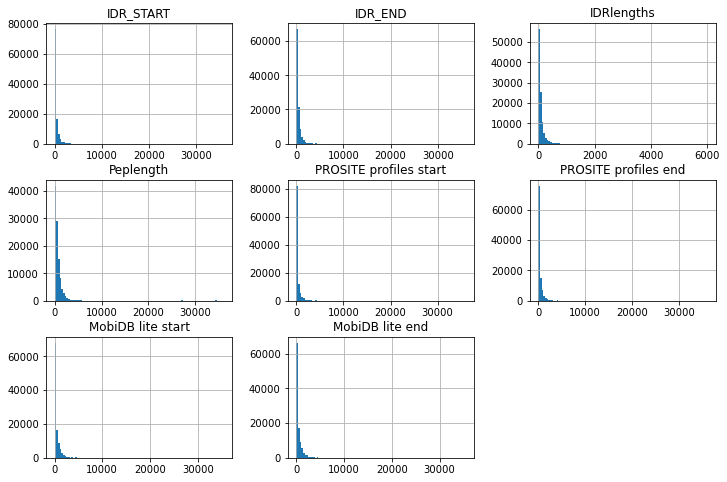

In [27]:
HG38_FULL_pep_IDRanot.to_csv('HG38_FULL_pep_IDRanot_RAW.csv', index=False)
HG38_FULL_pep_IDRanot.hist(bins = 100, figsize=(12,8),)

In [28]:
#Define C-terminal as being 20aa downstream of the Start of the protein for Mobi IDR
IsCt_Mobi = np.where((HG38_FULL_pep_IDRanot["MobiDB lite start"] >= 20), True, False)
HG38_FULL_pep_IDRanot["IsCt_Mobi"] = IsCt_Mobi
HG38_FULL_pep_IDRanot.info()
HG38_FULL_pep_IDRanot.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106447 entries, 0 to 106446
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      106447 non-null  object 
 1   IDR_START               106447 non-null  int64  
 2   IDR_END                 106447 non-null  int64  
 3   IDRlengths              106447 non-null  int64  
 4   Peplength               106447 non-null  int64  
 5   chromosome              106276 non-null  object 
 6   start                   106276 non-null  object 
 7   end                     106276 non-null  object 
 8   transcript              106276 non-null  object 
 9   gene_symbol             106276 non-null  object 
 10  description             106276 non-null  object 
 11  accession               106276 non-null  object 
 12  GeneID                  106276 non-null  object 
 13  PROSITE profiles ID     106447 non-null  object 
 14  PROSITE profiles sta

,ID,IDR_START,IDR_END,IDRlengths,Peplength,chromosome,start,end,transcript,gene_symbol,description,accession,GeneID,PROSITE profiles ID,PROSITE profiles start,PROSITE profiles end,MobiDB lite,MobiDB lite start,MobiDB lite end,IsCt_Mobi
0,ENSP00000374892.2,61,115,54,115,7,142455174,142455635,ENST00000390369.2,TRBV7-4,T cell receptor beta variable 7-4 (gene/pseudo...,HGNC:12238,ENSG00000253409,Nodomain,0.0,0.0,NoModi,0.0,0.0,False
1,ENSP00000483468.1,78,114,36,114,7,142601628,142602360,ENST00000619103.1,TRBV17,T cell receptor beta variable 17 (non-functional),HGNC:12192,ENSG00000277880,Nodomain,0.0,0.0,NoModi,0.0,0.0,False
2,ENSP00000374897.3,73,115,42,115,7,142492132,142492673,ENST00000390374.3,TRBV7-6,T cell receptor beta variable 7-6,HGNC:12240,ENSG00000211727,Nodomain,0.0,0.0,NoModi,0.0,0.0,False
3,ENSP00000452526.1,74,112,38,112,14,22052514,22053056,ENST00000390449.3,TRAV21,T cell receptor alpha variable 21,HGNC:12118,ENSG00000211801,Nodomain,0.0,0.0,NoModi,0.0,0.0,False
4,ENSP00000489072.1,70,115,45,115,7,142352819,142353358,ENST00000634605.1,TRBV7-2,T cell receptor beta variable 7-2,HGNC:12236,ENSG00000282939,Nodomain,0.0,0.0,NoModi,0.0,0.0,False


In [29]:
#Define C-terminal as being 20aa downstream of the Start of the protein for Metapredict IDR
IsCt_Meta = np.where(HG38_FULL_pep_IDRanot["IDR_START"] >= 20, True, False)
HG38_FULL_pep_IDRanot["IsCt_Meta"] = IsCt_Meta
HG38_FULL_pep_IDRanot.info()
HG38_FULL_pep_IDRanot.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106447 entries, 0 to 106446
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      106447 non-null  object 
 1   IDR_START               106447 non-null  int64  
 2   IDR_END                 106447 non-null  int64  
 3   IDRlengths              106447 non-null  int64  
 4   Peplength               106447 non-null  int64  
 5   chromosome              106276 non-null  object 
 6   start                   106276 non-null  object 
 7   end                     106276 non-null  object 
 8   transcript              106276 non-null  object 
 9   gene_symbol             106276 non-null  object 
 10  description             106276 non-null  object 
 11  accession               106276 non-null  object 
 12  GeneID                  106276 non-null  object 
 13  PROSITE profiles ID     106447 non-null  object 
 14  PROSITE profiles sta

,ID,IDR_START,IDR_END,IDRlengths,Peplength,chromosome,start,end,transcript,gene_symbol,...,accession,GeneID,PROSITE profiles ID,PROSITE profiles start,PROSITE profiles end,MobiDB lite,MobiDB lite start,MobiDB lite end,IsCt_Mobi,IsCt_Meta
0,ENSP00000374892.2,61,115,54,115,7,142455174,142455635,ENST00000390369.2,TRBV7-4,...,HGNC:12238,ENSG00000253409,Nodomain,0.0,0.0,NoModi,0.0,0.0,False,True
1,ENSP00000483468.1,78,114,36,114,7,142601628,142602360,ENST00000619103.1,TRBV17,...,HGNC:12192,ENSG00000277880,Nodomain,0.0,0.0,NoModi,0.0,0.0,False,True
2,ENSP00000374897.3,73,115,42,115,7,142492132,142492673,ENST00000390374.3,TRBV7-6,...,HGNC:12240,ENSG00000211727,Nodomain,0.0,0.0,NoModi,0.0,0.0,False,True
3,ENSP00000452526.1,74,112,38,112,14,22052514,22053056,ENST00000390449.3,TRAV21,...,HGNC:12118,ENSG00000211801,Nodomain,0.0,0.0,NoModi,0.0,0.0,False,True
4,ENSP00000489072.1,70,115,45,115,7,142352819,142353358,ENST00000634605.1,TRBV7-2,...,HGNC:12236,ENSG00000282939,Nodomain,0.0,0.0,NoModi,0.0,0.0,False,True


In [30]:
IsMobiMetaafterDomain = np.where((HG38_FULL_pep_IDRanot["MobiDB lite start"] > HG38_FULL_pep_IDRanot["PROSITE profiles start"]) | (HG38_FULL_pep_IDRanot["IDR_START"] > HG38_FULL_pep_IDRanot["PROSITE profiles start"]) , True, False)
HG38_FULL_pep_IDRanot["IsMobiMetaafterDomain"] = IsMobiMetaafterDomain
HG38_FULL_pep_IDRanot.info()
HG38_FULL_pep_IDRanot.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106447 entries, 0 to 106446
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      106447 non-null  object 
 1   IDR_START               106447 non-null  int64  
 2   IDR_END                 106447 non-null  int64  
 3   IDRlengths              106447 non-null  int64  
 4   Peplength               106447 non-null  int64  
 5   chromosome              106276 non-null  object 
 6   start                   106276 non-null  object 
 7   end                     106276 non-null  object 
 8   transcript              106276 non-null  object 
 9   gene_symbol             106276 non-null  object 
 10  description             106276 non-null  object 
 11  accession               106276 non-null  object 
 12  GeneID                  106276 non-null  object 
 13  PROSITE profiles ID     106447 non-null  object 
 14  PROSITE profiles sta

,ID,IDR_START,IDR_END,IDRlengths,Peplength,chromosome,start,end,transcript,gene_symbol,...,GeneID,PROSITE profiles ID,PROSITE profiles start,PROSITE profiles end,MobiDB lite,MobiDB lite start,MobiDB lite end,IsCt_Mobi,IsCt_Meta,IsMobiMetaafterDomain
0,ENSP00000374892.2,61,115,54,115,7,142455174,142455635,ENST00000390369.2,TRBV7-4,...,ENSG00000253409,Nodomain,0.0,0.0,NoModi,0.0,0.0,False,True,True
1,ENSP00000483468.1,78,114,36,114,7,142601628,142602360,ENST00000619103.1,TRBV17,...,ENSG00000277880,Nodomain,0.0,0.0,NoModi,0.0,0.0,False,True,True
2,ENSP00000374897.3,73,115,42,115,7,142492132,142492673,ENST00000390374.3,TRBV7-6,...,ENSG00000211727,Nodomain,0.0,0.0,NoModi,0.0,0.0,False,True,True
3,ENSP00000452526.1,74,112,38,112,14,22052514,22053056,ENST00000390449.3,TRAV21,...,ENSG00000211801,Nodomain,0.0,0.0,NoModi,0.0,0.0,False,True,True
4,ENSP00000489072.1,70,115,45,115,7,142352819,142353358,ENST00000634605.1,TRBV7-2,...,ENSG00000282939,Nodomain,0.0,0.0,NoModi,0.0,0.0,False,True,True


In [31]:
HG38_FULL_pep_IDRanot.groupby(["IsCt_Mobi", "IsCt_Meta", "IsMobiMetaafterDomain"]).size()

IsCt_Mobi  IsCt_Meta  IsMobiMetaafterDomain
False      False      False                    18427
                      True                      3722
           True       False                     2654
                      True                     16707
True       False      False                     3910
                      True                     13785
           True       False                     8999
                      True                     38243
dtype: int64

In [32]:
HG38_FULL_pep_IDRanot.to_csv('HG38_FULL_pep_IDRanotTested.csv', index = False)

In [33]:
HG38_FULL_pep_IDRanot.dropna(subset=['chromosome'],inplace = True)
HG38_FULL_pep_IDRanot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106276 entries, 0 to 106446
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      106276 non-null  object 
 1   IDR_START               106276 non-null  int64  
 2   IDR_END                 106276 non-null  int64  
 3   IDRlengths              106276 non-null  int64  
 4   Peplength               106276 non-null  int64  
 5   chromosome              106276 non-null  object 
 6   start                   106276 non-null  object 
 7   end                     106276 non-null  object 
 8   transcript              106276 non-null  object 
 9   gene_symbol             106276 non-null  object 
 10  description             106276 non-null  object 
 11  accession               106276 non-null  object 
 12  GeneID                  106276 non-null  object 
 13  PROSITE profiles ID     106276 non-null  object 
 14  PROSITE profiles sta

In [71]:
HG38_FULL_pep_IDRanotF = HG38_FULL_pep_IDRanot[(HG38_FULL_pep_IDRanot['IsMobiMetaafterDomain'] == True ) & (HG38_FULL_pep_IDRanot['IsCt_Meta'] == True)]
HG38_FULL_pep_IDRanotF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54855 entries, 0 to 106438
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      54855 non-null  object 
 1   IDR_START               54855 non-null  int64  
 2   IDR_END                 54855 non-null  int64  
 3   IDRlengths              54855 non-null  int64  
 4   Peplength               54855 non-null  int64  
 5   chromosome              54855 non-null  object 
 6   start                   54855 non-null  object 
 7   end                     54855 non-null  object 
 8   transcript              54855 non-null  object 
 9   gene_symbol             54855 non-null  object 
 10  description             54855 non-null  object 
 11  accession               54855 non-null  object 
 12  GeneID                  54855 non-null  object 
 13  PROSITE profiles ID     54855 non-null  object 
 14  PROSITE profiles start  54855 non-nul

In [72]:
HG38_FULL_pep_IDRanotF.to_csv('HG38_FULL_pep_IDRanotF.csv', index = False)

In [73]:
HG38_FULL_pep_IDRanotF = pd.read_csv('HG38_FULL_pep_IDRanotF.csv',low_memory=False)

In [74]:
HG38_FULL_pep_Geno_Canonical = pd.read_csv('HG38_FULL_pep_Geno_Canonical.csv',low_memory=False)

In [75]:
HG38_FULL_pep_IDRanotF = pd.merge(HG38_FULL_pep_IDRanotF, HG38_FULL_pep_Geno_Canonical, how="left", left_on="ID", right_on="Protein stable ID version")
HG38_FULL_pep_IDRanotF.head()

,ID,IDR_START,IDR_END,IDRlengths,Peplength,chromosome,start,end,transcript,gene_symbol,...,PROSITE profiles end,MobiDB lite,MobiDB lite start,MobiDB lite end,IsCt_Mobi,IsCt_Meta,IsMobiMetaafterDomain,Protein stable ID version,GENCODE basic annotation,Ensembl Canonical
0,ENSP00000374892.2,61,115,54,115,7,142455174,142455635,ENST00000390369.2,TRBV7-4,...,0.0,NoModi,0.0,0.0,False,True,True,ENSP00000374892.2,GENCODE basic,1.0
1,ENSP00000483468.1,78,114,36,114,7,142601628,142602360,ENST00000619103.1,TRBV17,...,0.0,NoModi,0.0,0.0,False,True,True,ENSP00000483468.1,GENCODE basic,1.0
2,ENSP00000374897.3,73,115,42,115,7,142492132,142492673,ENST00000390374.3,TRBV7-6,...,0.0,NoModi,0.0,0.0,False,True,True,ENSP00000374897.3,GENCODE basic,1.0
3,ENSP00000452526.1,74,112,38,112,14,22052514,22053056,ENST00000390449.3,TRAV21,...,0.0,NoModi,0.0,0.0,False,True,True,ENSP00000452526.1,GENCODE basic,1.0
4,ENSP00000489072.1,70,115,45,115,7,142352819,142353358,ENST00000634605.1,TRBV7-2,...,0.0,NoModi,0.0,0.0,False,True,True,ENSP00000489072.1,GENCODE basic,1.0


In [76]:
HG38_FULL_pep_IDRanotF["GENCODE basic annotation"].value_counts()


GENCODE basic    40828
Name: GENCODE basic annotation, dtype: int64

In [77]:
HG38_FULL_pep_IDRanotF["Ensembl Canonical"].value_counts()

1.0    14762
Name: Ensembl Canonical, dtype: int64

In [78]:
CheckIDRCterm = np.where((HG38_FULL_pep_IDRanotF["IDR_END"] == HG38_FULL_pep_IDRanotF["Peplength"]) | (HG38_FULL_pep_IDRanotF["MobiDB lite end"] == HG38_FULL_pep_IDRanotF["Peplength"]) , True, False)
HG38_FULL_pep_IDRanotF["CheckIDRCterm"] = CheckIDRCterm
#HG38_FULL_pep_IDRanotF.info()

In [79]:
HG38_FULL_pep_IDRanotF.CheckIDRCterm.value_counts()

True     32270
False    22619
Name: CheckIDRCterm, dtype: int64

In [80]:
HG38_FULL_pep_IDRanotF['TrueIDRend'] = np.maximum(HG38_FULL_pep_IDRanotF["IDR_END"], HG38_FULL_pep_IDRanotF["MobiDB lite end"])
HG38_FULL_pep_IDRanotF['TrueIDRstart'] = np.maximum(HG38_FULL_pep_IDRanotF["IDR_START"], HG38_FULL_pep_IDRanotF["MobiDB lite start"])

In [81]:
HG38_FULL_pep_IDRanotF["RemaningSeq"] =  HG38_FULL_pep_IDRanotF["Peplength"] - HG38_FULL_pep_IDRanotF["TrueIDRend"]
HG38_FULL_pep_IDRanotF["RemaningSeq%"] = 100*(HG38_FULL_pep_IDRanotF["RemaningSeq"]/HG38_FULL_pep_IDRanotF["Peplength"])

In [82]:
HG38_FULL_pep_IDRanotF[["RemaningSeq"]].plot_bokeh.hist(bins = np.arange(1, 2000, 100), vertical_xlabel=True, show_average=True)
#HG38_FULL_pep_IDRanotF[["RemaningSeq"]].hist(bins = 100, figsize=(12,4), range=[1, 2000])

Figure(id='2007', ...)

In [83]:
HG38_FULL_pep_IDRanotF[["RemaningSeq"]].mean()

RemaningSeq    113.756673
dtype: float64

In [84]:
HG38_FULL_pep_IDRanotF.to_csv("HG38_FULL_pep_IDRanotF.csv", index = False)

In [85]:
HG38_FULL_pep_IDRanotFF = HG38_FULL_pep_IDRanotF.dropna(subset=["GENCODE basic annotation"])

HG38_FULL_pep_IDRanotFF.head()

,ID,IDR_START,IDR_END,IDRlengths,Peplength,chromosome,start,end,transcript,gene_symbol,...,IsCt_Meta,IsMobiMetaafterDomain,Protein stable ID version,GENCODE basic annotation,Ensembl Canonical,CheckIDRCterm,TrueIDRend,TrueIDRstart,RemaningSeq,RemaningSeq%
0,ENSP00000374892.2,61,115,54,115,7,142455174,142455635,ENST00000390369.2,TRBV7-4,...,True,True,ENSP00000374892.2,GENCODE basic,1.0,True,115.0,61.0,0.0,0.0
1,ENSP00000483468.1,78,114,36,114,7,142601628,142602360,ENST00000619103.1,TRBV17,...,True,True,ENSP00000483468.1,GENCODE basic,1.0,True,114.0,78.0,0.0,0.0
2,ENSP00000374897.3,73,115,42,115,7,142492132,142492673,ENST00000390374.3,TRBV7-6,...,True,True,ENSP00000374897.3,GENCODE basic,1.0,True,115.0,73.0,0.0,0.0
3,ENSP00000452526.1,74,112,38,112,14,22052514,22053056,ENST00000390449.3,TRAV21,...,True,True,ENSP00000452526.1,GENCODE basic,1.0,True,112.0,74.0,0.0,0.0
4,ENSP00000489072.1,70,115,45,115,7,142352819,142353358,ENST00000634605.1,TRBV7-2,...,True,True,ENSP00000489072.1,GENCODE basic,1.0,True,115.0,70.0,0.0,0.0


In [86]:
HG38_FULL_pep_IDRanotFF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40828 entries, 0 to 54888
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         40828 non-null  object 
 1   IDR_START                  40828 non-null  int64  
 2   IDR_END                    40828 non-null  int64  
 3   IDRlengths                 40828 non-null  int64  
 4   Peplength                  40828 non-null  int64  
 5   chromosome                 40828 non-null  object 
 6   start                      40828 non-null  int64  
 7   end                        40828 non-null  int64  
 8   transcript                 40828 non-null  object 
 9   gene_symbol                40828 non-null  object 
 10  description                40828 non-null  object 
 11  accession                  40636 non-null  object 
 12  GeneID                     40828 non-null  object 
 13  PROSITE profiles ID        40828 non-null  obj

In [87]:
HG38_FULL_pep_IDRanotF[["RemaningSeq%"]].plot_bokeh.hist(bins = np.arange(1, 100, 1), vertical_xlabel=True, show_average=True)

Figure(id='2248', ...)

In [88]:
#Define remaning cut-off pep lengh as 20% because local minimum
HG38_FULL_pep_IDRanotF20 = HG38_FULL_pep_IDRanotFF.drop(HG38_FULL_pep_IDRanotFF[HG38_FULL_pep_IDRanotFF["RemaningSeq%"] >= 20].index)

In [89]:
HG38_FULL_pep_IDRanotF20.info() #about 32833 IDRs in 11132 loci

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33888 entries, 0 to 54888
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         33888 non-null  object 
 1   IDR_START                  33888 non-null  int64  
 2   IDR_END                    33888 non-null  int64  
 3   IDRlengths                 33888 non-null  int64  
 4   Peplength                  33888 non-null  int64  
 5   chromosome                 33888 non-null  object 
 6   start                      33888 non-null  int64  
 7   end                        33888 non-null  int64  
 8   transcript                 33888 non-null  object 
 9   gene_symbol                33888 non-null  object 
 10  description                33888 non-null  object 
 11  accession                  33759 non-null  object 
 12  GeneID                     33888 non-null  object 
 13  PROSITE profiles ID        33888 non-null  obj

In [90]:
HG38_FULL_pep_IDRanotF20.to_csv("HG38_FULL_pep_IDRanotF20.csv", index = False)

In [91]:
s1 = HG38_FULL_pep_IDRanotF20[["IDRlengths"]].plot_bokeh.hist(bins = np.arange(1,500, 10), vertical_xlabel=True, show_average=True)
s2 = HG38_FULL_pep_IDRanotF20[["Peplength"]].plot_bokeh.hist(bins = np.arange(1, 3500, 100), vertical_xlabel=True, show_average=True)

In [92]:
HG38_FULL_pep_IDRanotF20.info()
HG38_FULL_pep_IDRanotF20.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33888 entries, 0 to 54888
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         33888 non-null  object 
 1   IDR_START                  33888 non-null  int64  
 2   IDR_END                    33888 non-null  int64  
 3   IDRlengths                 33888 non-null  int64  
 4   Peplength                  33888 non-null  int64  
 5   chromosome                 33888 non-null  object 
 6   start                      33888 non-null  int64  
 7   end                        33888 non-null  int64  
 8   transcript                 33888 non-null  object 
 9   gene_symbol                33888 non-null  object 
 10  description                33888 non-null  object 
 11  accession                  33759 non-null  object 
 12  GeneID                     33888 non-null  object 
 13  PROSITE profiles ID        33888 non-null  obj

,ID,IDR_START,IDR_END,IDRlengths,Peplength,chromosome,start,end,transcript,gene_symbol,...,IsCt_Meta,IsMobiMetaafterDomain,Protein stable ID version,GENCODE basic annotation,Ensembl Canonical,CheckIDRCterm,TrueIDRend,TrueIDRstart,RemaningSeq,RemaningSeq%
0,ENSP00000374892.2,61,115,54,115,7,142455174,142455635,ENST00000390369.2,TRBV7-4,...,True,True,ENSP00000374892.2,GENCODE basic,1.0,True,115.0,61.0,0.0,0.0
1,ENSP00000483468.1,78,114,36,114,7,142601628,142602360,ENST00000619103.1,TRBV17,...,True,True,ENSP00000483468.1,GENCODE basic,1.0,True,114.0,78.0,0.0,0.0
2,ENSP00000374897.3,73,115,42,115,7,142492132,142492673,ENST00000390374.3,TRBV7-6,...,True,True,ENSP00000374897.3,GENCODE basic,1.0,True,115.0,73.0,0.0,0.0
3,ENSP00000452526.1,74,112,38,112,14,22052514,22053056,ENST00000390449.3,TRAV21,...,True,True,ENSP00000452526.1,GENCODE basic,1.0,True,112.0,74.0,0.0,0.0
4,ENSP00000489072.1,70,115,45,115,7,142352819,142353358,ENST00000634605.1,TRBV7-2,...,True,True,ENSP00000489072.1,GENCODE basic,1.0,True,115.0,70.0,0.0,0.0


In [93]:
HG38_FULL_pep_IDRanotF20["TrueIDRlengh"] = HG38_FULL_pep_IDRanotF20["TrueIDRend"] - HG38_FULL_pep_IDRanotF20["TrueIDRstart"]

In [94]:
HG38_FULL_pep_IDRanotF20[["TrueIDRlengh"]].plot_bokeh.hist(bins = np.arange(1,1000, 10), vertical_xlabel=True, show_average=True)


Figure(id='3043', ...)

In [95]:
HG38_FULL_pep_IDRanotF20.to_csv("HG38_Canonical_pep_IDRanotF20.csv", index = False)

In [96]:
AnnotationTF = pd.read_csv('IDRtable_omegascored.csv')
AnnotationTF.head()

,Fasta,IDR,IDRCoord,IDRlenght,GeneName,RefSeqID,RefSeqIDPep,Gene_family,Entrez_ID,Protein_ID,GeneID,FactorType,GeneLenght,OmegaScore
0,CCNA2_hg19_NM_001237_IDR_1.fa,1,1-181,181,CCNA2,NM_001237,NP_001228,Cell Cycle,890,ENSP00000274026,ENSG00000145386,Co-factor,432,0.221039
1,CCNE1_hg19_NM_001238_IDR_1.fa,1,1-101,101,CCNE1,NM_001238,NP_001229,Cell Cycle,898,ENSP00000262643,ENSG00000105173,Co-factor,410,0.052645
2,CCNH_hg19_NM_001364075_IDR_3.fa,3,224-282,59,CCNH,NM_001364075,NP_001351004,Cell Cycle,902,ENSP00000256897,ENSG00000134480,Co-factor,325,NaN
3,CCNK_hg19_NM_001099402_IDR_6.fa,6,257-580,324,CCNK,NM_001099402,NP_001092872,Cell Cycle,8812,ENSP00000374529,ENSG00000090061,Co-factor,580,0.396751
4,CCNT1_hg19_NM_001240_IDR_4.fa,4,263-656,394,CCNT1,NM_001240,NP_001231,Cell Cycle,904,ENSP00000261900,ENSG00000129315,Co-factor,726,0.184163


In [97]:
AnnotationTF = AnnotationTF.drop(["Fasta", "IDR","IDRCoord","IDRlenght", "GeneName", "RefSeqID", "RefSeqIDPep", "Entrez_ID", "Protein_ID", "GeneLenght", "OmegaScore"],1)

In [98]:
AnnotationTF.head()
AnnotationTF = AnnotationTF.drop_duplicates(subset=['GeneID'], keep='last')
AnnotationTF.info()
AnnotationTF.to_csv("AnnotationTF.csv", index = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421 entries, 0 to 2451
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Gene_family  2421 non-null   object
 1   GeneID       2420 non-null   object
 2   FactorType   2421 non-null   object
dtypes: object(3)
memory usage: 75.7+ KB


In [99]:
HG38_FULL_pep_IDRanotF20 = pd.merge(HG38_FULL_pep_IDRanotF20, AnnotationTF, how="left", on="GeneID")
HG38_FULL_pep_IDRanotF20.head()

,ID,IDR_START,IDR_END,IDRlengths,Peplength,chromosome,start,end,transcript,gene_symbol,...,GENCODE basic annotation,Ensembl Canonical,CheckIDRCterm,TrueIDRend,TrueIDRstart,RemaningSeq,RemaningSeq%,TrueIDRlengh,Gene_family,FactorType
0,ENSP00000374892.2,61,115,54,115,7,142455174,142455635,ENST00000390369.2,TRBV7-4,...,GENCODE basic,1.0,True,115.0,61.0,0.0,0.0,54.0,NaN,NaN
1,ENSP00000483468.1,78,114,36,114,7,142601628,142602360,ENST00000619103.1,TRBV17,...,GENCODE basic,1.0,True,114.0,78.0,0.0,0.0,36.0,NaN,NaN
2,ENSP00000374897.3,73,115,42,115,7,142492132,142492673,ENST00000390374.3,TRBV7-6,...,GENCODE basic,1.0,True,115.0,73.0,0.0,0.0,42.0,NaN,NaN
3,ENSP00000452526.1,74,112,38,112,14,22052514,22053056,ENST00000390449.3,TRAV21,...,GENCODE basic,1.0,True,112.0,74.0,0.0,0.0,38.0,NaN,NaN
4,ENSP00000489072.1,70,115,45,115,7,142352819,142353358,ENST00000634605.1,TRBV7-2,...,GENCODE basic,1.0,True,115.0,70.0,0.0,0.0,45.0,NaN,NaN


In [100]:
HG38_FULL_pep_IDRanotF20.to_csv("HG38_Canonical_pep_IDRanotF20.csv", index=False)

In [101]:
HG38_Canonical_pep_IDRanotF20 = pd.read_csv('HG38_Canonical_pep_IDRanotF20.csv')
HG38_Canonical_pep_IDRanotF20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33888 entries, 0 to 33887
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         33888 non-null  object 
 1   IDR_START                  33888 non-null  int64  
 2   IDR_END                    33888 non-null  int64  
 3   IDRlengths                 33888 non-null  int64  
 4   Peplength                  33888 non-null  int64  
 5   chromosome                 33888 non-null  object 
 6   start                      33888 non-null  int64  
 7   end                        33888 non-null  int64  
 8   transcript                 33888 non-null  object 
 9   gene_symbol                33888 non-null  object 
 10  description                33888 non-null  object 
 11  accession                  33759 non-null  object 
 12  GeneID                     33888 non-null  object 
 13  PROSITE profiles ID        33888 non-null  obj

In [102]:
HG38_Canonical_pep_IDRanotF20["IDS"] = HG38_Canonical_pep_IDRanotF20["ID"]
HG38_Canonical_pep_IDRanotF20[['PEPId','version']] = HG38_Canonical_pep_IDRanotF20.IDS.str.split(".",expand=True,)
HG38_Canonical_pep_IDRanotF20 = HG38_Canonical_pep_IDRanotF20.drop("version", 1)
HG38_Canonical_pep_IDRanotF20 = HG38_Canonical_pep_IDRanotF20.drop("IDS",1)

In [103]:
HG38_Canonical_pep_IDRanotF20[['TrscId','version']] = HG38_Canonical_pep_IDRanotF20.transcript.str.split(".",expand=True,)
HG38_Canonical_pep_IDRanotF20 = HG38_Canonical_pep_IDRanotF20.drop("version", 1)
HG38_Canonical_pep_IDRanotF20["TIDRstart_cds"] = HG38_Canonical_pep_IDRanotF20["TrueIDRstart"]*3
HG38_Canonical_pep_IDRanotF20["TIDRend_cds"] = (HG38_Canonical_pep_IDRanotF20["TrueIDRend"]*3)+3
HG38_Canonical_pep_IDRanotF20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33888 entries, 0 to 33887
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         33888 non-null  object 
 1   IDR_START                  33888 non-null  int64  
 2   IDR_END                    33888 non-null  int64  
 3   IDRlengths                 33888 non-null  int64  
 4   Peplength                  33888 non-null  int64  
 5   chromosome                 33888 non-null  object 
 6   start                      33888 non-null  int64  
 7   end                        33888 non-null  int64  
 8   transcript                 33888 non-null  object 
 9   gene_symbol                33888 non-null  object 
 10  description                33888 non-null  object 
 11  accession                  33759 non-null  object 
 12  GeneID                     33888 non-null  object 
 13  PROSITE profiles ID        33888 non-null  obj

In [104]:
HG38_Canonical_pep_IDRanotF20_ = HG38_Canonical_pep_IDRanotF20.sort_values('RemaningSeq%').drop_duplicates('GeneID', keep='first')
HG38_Canonical_pep_IDRanotF20_.to_csv("HG38_Canonical_pep_IDRanotF20_.csv", index = False)
HG38_Canonical_pep_IDRanotF20_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9303 entries, 0 to 22617
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         9303 non-null   object 
 1   IDR_START                  9303 non-null   int64  
 2   IDR_END                    9303 non-null   int64  
 3   IDRlengths                 9303 non-null   int64  
 4   Peplength                  9303 non-null   int64  
 5   chromosome                 9303 non-null   object 
 6   start                      9303 non-null   int64  
 7   end                        9303 non-null   int64  
 8   transcript                 9303 non-null   object 
 9   gene_symbol                9303 non-null   object 
 10  description                9303 non-null   object 
 11  accession                  9194 non-null   object 
 12  GeneID                     9303 non-null   object 
 13  PROSITE profiles ID        9303 non-null   obje

In [105]:
HG38_Canonical_pep_IDRanotF20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33888 entries, 0 to 33887
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         33888 non-null  object 
 1   IDR_START                  33888 non-null  int64  
 2   IDR_END                    33888 non-null  int64  
 3   IDRlengths                 33888 non-null  int64  
 4   Peplength                  33888 non-null  int64  
 5   chromosome                 33888 non-null  object 
 6   start                      33888 non-null  int64  
 7   end                        33888 non-null  int64  
 8   transcript                 33888 non-null  object 
 9   gene_symbol                33888 non-null  object 
 10  description                33888 non-null  object 
 11  accession                  33759 non-null  object 
 12  GeneID                     33888 non-null  object 
 13  PROSITE profiles ID        33888 non-null  obj

In [2]:
HG38_Canonical_pep_IDRanotF20 = pd.read_csv('HG38_Canonical_pep_IDRanotF20_.csv')

In [3]:
HG38_CanonicalPEP_IDRs_coord = HG38_Canonical_pep_IDRanotF20[["ID", "TrueIDRstart", "TrueIDRend"]]
HG38_CanonicalPEP_IDRs_coord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9303 entries, 0 to 9302
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            9303 non-null   object 
 1   TrueIDRstart  9303 non-null   float64
 2   TrueIDRend    9303 non-null   float64
dtypes: float64(2), object(1)
memory usage: 218.2+ KB


In [4]:
HG38_CanonicalPEP_IDRs_coord = HG38_Canonical_pep_IDRanotF20.rename(columns= {"TrueIDRstart" : "start", "TrueIDRend" : "end"})

In [5]:
HG38_CanonicalPEP_IDRs_coord.to_csv("HG38_CanonicalPEP_IDRs_coord.csv", index = False)